# Advanced Image Captioning Project

## Introduction
This project embarks on the ambitious task of building an advanced Image Captioning system, leveraging state-of-the-art machine learning techniques and neural network architectures. Image Captioning lies at the intersection of computer vision and natural language processing, where the objective is to generate descriptive, coherent, and contextually relevant captions for images.

## Project Overview
The goal is to create a model that not only understands the content of an image but also can articulate this understanding in a meaningful way. This involves intricate processes like feature extraction from images, understanding the contextual relevance, and converting these insights into human-readable text.

## Technical Details
- **Libraries & Modules**: The project employs a variety of libraries, including `numpy` for numerical operations, `matplotlib` for visualizations, and `keras` for building deep learning models.
- **Image Processing**: Images are processed using the powerful `InceptionV3` model from Keras, known for its efficiency in image classification tasks.
- **Natural Language Processing**: Text processing is managed using Keras utilities like `Tokenizer` and `pad_sequences` to convert text data into a format suitable for neural network training.
- **Neural Network Architecture**: The core of the project lies in its sophisticated neural network design which includes layers like `LSTM`, `Embedding`, `Dense`, and `Bidirectional`, essential for capturing the complexities of language and image features.
- **Objective**: The trained model aims to analyze an image and generate a caption that is not only accurate in describing the image but also contextually and grammatically coherent.

In the following sections, we dive into the specifics of data preparation, model building, training, and evaluation, unfolding the steps involved in bringing this intricate system to life.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
import glob
from PIL import Image
from time import time

from keras.preprocessing import image as keras_image
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout, Bidirectional, add
from keras.applications.inception_v3 import preprocess_input, InceptionV3
from keras.models import Model
from keras.utils import to_categorical
from keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LSTM, BatchNormalization, LeakyReLU, Bidirectional, Concatenate
from tensorflow.keras.regularizers import L1L2

# Data Preparation

In this section, we focus on preparing the data required for training the Image Captioning model. The data is sourced from the well-known Flickr8k dataset, which is a collection of 8,000 images each paired with five different captions, providing a rich dataset for our task.

### Data Sources
- **Flickr8k Text Data**: Contains the captions for the images. We use `flickr8k.token.txt` for the captions, `flickr_8k.trainImages.txt` for training image references, and `flickr_8k.testImages.txt` for testing image references.
- **Flickr8k Images**: The `Images/` directory contains the actual images referenced in the text files.
- **GloVe Embeddings**: For processing the textual data, we utilize the pre-trained GloVe (Global Vectors for Word Representation) embeddings available at `glove-global-vectors-for-word-representation/`.

### Data Loading
The process begins with loading the captions and the associated image paths. This involves reading the `token_path` to fetch the captions, and the paths `train_images_path` and `test_images_path` to gather the lists of images for training and testing purposes.

### Purpose
This step is crucial as it sets up our dataset, aligning the images with their corresponding captions, which is a key aspect of training our model to understand and generate relevant descriptions for images.

In the next steps, we'll delve into further processing these data elements, ensuring they are in the appropriate format for feeding into our neural network.


In [2]:
token_path = "../input/flickr8k-text/flickr8k.token.txt"
train_images_path = '../input/flickr8k-text/flickr_8k.trainImages.txt'
test_images_path = '../input/flickr8k-text/flickr_8k.testImages.txt'
images_path = '../input/flickr-8k-images-with-captions/Images/'
glove_path = '../input/glove-global-vectors-for-word-representation/'

doc = open(token_path,'r').read()

# Caption Processing

In this section, we process the loaded captions to create a structured format that can be easily utilized for training. Our goal is to associate each image with its corresponding set of captions.

### Caption Mapping
- We create a dictionary named `descriptions` where each key is an image ID, and the value is a list of captions associated with that image.
- By iterating over each line of the `doc` (the content of `flickr8k.token.txt`), we split the line to extract the image ID and its corresponding caption.
- If an image ID isn't already in our `descriptions` dictionary, we add it along with its associated caption.

### Output
- After processing all lines, we print the total number of unique images processed. This count represents the distinct images we have captions for, which will be crucial in the next steps of our project where these captions are used to generate descriptions for unseen images.

This step is vital for creating a well-structured dataset, ensuring that our model has the necessary data in an accessible and organized format. The process aids in aligning textual data (captions) with visual data (images), a foundational aspect of our Image Captioning task.


In [3]:
descriptions = dict()
for line in doc.split('\n'):
        tokens = line.split()
        if len(line) > 2:
          image_id = tokens[0].split('.')[0]
          image_desc = ' '.join(tokens[1:])
          if image_id not in descriptions:
              descriptions[image_id] = list()
          descriptions[image_id].append(image_desc)
        
print(f'Total images: {len(descriptions)}')

Total images: 8092


# Text Normalization for Image Captions

In this section, we perform text normalization on the captions to standardize and simplify the textual data. This process is crucial for reducing complexity and improving the model's learning efficiency.

### Removing Punctuation and Lowercasing
- We create a translation table named `table` using `str.maketrans`, which is set to remove all punctuation marks.
- For each image in our `descriptions` dictionary, we iterate through its list of captions.
- Each caption is split into words, and two primary transformations are applied:
  - **Lowercasing**: All words are converted to lowercase to ensure uniformity. This step helps the model in not treating the same words in different cases as different words.
  - **Punctuation Removal**: All punctuation marks are removed from each word using the translation table. This simplifies the captions and focuses on the essential elements of the text.

### Reassembling Processed Captions
- After processing each word in a caption, we reassemble the caption into a complete sentence.
- The processed caption replaces the original one in the `descriptions` dictionary.

This text normalization process is a fundamental step in natural language processing. It helps in reducing the variations in the textual data, allowing the model to focus on the core linguistic elements of the captions. Simplified and consistent textual data lead to better performance in training image captioning models.


In [4]:
table = str.maketrans('', '', string.punctuation)
for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc = desc_list[i]
        desc = desc.split()
        desc = [word.lower() for word in desc]
        desc = [w.translate(table) for w in desc]
        desc_list[i] =  ' '.join(desc)

# CREATE A VOCABULARY

In [5]:
vocabulary = set()
for key in descriptions.keys():
        [vocabulary.update(d.split()) for d in descriptions[key]]
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8828


# Vocabulary Creation from Normalized Captions

In this part of the process, we construct the essential vocabulary from our normalized image captions. This vocabulary is the cornerstone of our model's linguistic comprehension.

### Steps to Create Vocabulary
- **Initialization**: We start with an empty set `vocabulary`. Sets are ideal for this task due to their inherent uniqueness and efficiency.
- **Iteration Over Captions**: For each image in the `descriptions` dictionary, we explore its associated captions.
- **Word Extraction**: We split each pre-processed caption into words, then add these to our `vocabulary`. This approach ensures each word is distinct and eliminates redundancy.

### Key Outcomes
- **Vocabulary Size**: After processing all captions, the total number of unique words (vocabulary size) is revealed. This metric is crucial as it reflects the textual diversity in our dataset.
- **Model Complexity and Richness**: The size of the vocabulary directly influences the model's complexity. A larger vocabulary, while more challenging to learn, can capture a wider range of linguistic nuances.

### Importance in Image Captioning
- **Fundamental for Training**: A robust vocabulary is critical for effectively training an image captioning model. It sets the stage for the linguistic scope the model will learn and generate.
- **Preparation for Further Processing**: This vocabulary lays the foundation for subsequent stages like tokenization and embedding, where words are transformed into formats conducive to model training.

Overall, this step is integral in preparing the linguistic aspect of our model, ensuring it has a broad and rich language base to learn from and generate meaningful captions.


In [6]:
lines = list()
for key, desc_list in descriptions.items():
    for desc in desc_list:
        lines.append(key + ' ' + desc)
new_descriptions = '\n'.join(lines)

# Preparing the Training Set

In this step, we're setting up our training set for the image captioning model:

1. **Reading Image Paths**: We access `train_images_path` to gather identifiers of images designated for training.
2. **Extracting Image IDs**: From each line in the training image file, image IDs are extracted and compiled into a `dataset` list.
3. **Creating Unique Training Set**: The list is converted to a set named `train` to ensure uniqueness.

This stage is pivotal as it defines the subset of images the model will learn from, forming the basis for training the image captioning system.


In [7]:
doc = open(train_images_path,'r').read()
dataset = list()
for line in doc.split('\n'):
    if len(line) > 1:
      identifier = line.split('.')[0]
      dataset.append(identifier)

train = set(dataset)

# Image Data Preparation

This section is dedicated to preparing the image data for our image captioning model. We segregate our images into training and testing sets, ensuring our model has a diverse range of data to learn from and be evaluated against.

### Loading and Splitting Image Data
- **Training Images**: We load image paths from `train_images_path` and compile a list `train_img` of training images. Each image path is verified to ensure it belongs to the training set.
- **Testing Images**: Similarly, we gather image paths from `test_images_path` and create a list `test_img` for testing images. This list includes only those images designated for model evaluation.

### Purpose of Segregating Images
- **Model Training**: The `train_img` set provides a wide range of images and associated captions for the model to learn from.
- **Model Evaluation**: The `test_img` set is crucial for assessing the model's performance and its ability to generalize to new, unseen images.

By carefully preparing our image data, we create a solid foundation for training a robust and efficient image captioning model. This step ensures that our model has access to varied and representative samples of images for both learning and validation purposes.


In [8]:
img = glob.glob(images_path + '*.jpg')
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
train_img = []
for i in img: 
    if i[len(images_path):] in train_images:
        train_img.append(i)

test_images = set(open(test_images_path, 'r').read().strip().split('\n'))
test_img = []
for i in img: 
    if i[len(images_path):] in test_images: 
        test_img.append(i)

# Preparing Image Captions for Training

In this section, we create a structured format for our image captions, transforming them into a format that is more suitable for training our model.

### Creating Training Descriptions
- **Dictionary for Descriptions**: We initialize `train_descriptions` as a dictionary to hold the processed captions associated with each image in the training set.
- **Adding Start and End Tokens**: For each caption, we prepend the token `'startseq'` and append `'endseq'`. These tokens serve as markers indicating the beginning and end of a caption. This technique is essential for the model to learn the structure of sentences.
- **Populating the Dictionary**: We iterate over each line in `new_descriptions`. If the image ID belongs to the training set, we process its caption and add it to `train_descriptions`.
- **Result**: Each entry in `train_descriptions` consists of an image ID and a list of its corresponding processed captions.

### Significance in Image Captioning
- These structured captions are crucial for training as they provide a clear start and endpoint for the model to generate captions.
- The consistent format across all captions aids in better learning and prediction by the model.

This careful preparation of captions ensures that our image captioning model is fed with data that is not only informative but also structured in a way that enhances the learning process.


In [9]:
train_descriptions = dict()
for line in new_descriptions.split('\n'):
    tokens = line.split()
    image_id, image_desc = tokens[0], tokens[1:]
    if image_id in train:
        if image_id not in train_descriptions:
            train_descriptions[image_id] = list()
        desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
        train_descriptions[image_id].append(desc)

# Compiling All Training Captions

Here, we gather all the captions from our training dataset into a single list. This compilation is a preparatory step for further linguistic processing and feature extraction.

### Creating a Comprehensive List of Captions
- We initialize an empty list `all_train_captions` to store all captions associated with the training images.
- We iterate over each image in our `train_descriptions` dictionary.
- For every image, we access its list of captions and add each caption to `all_train_captions`.

### Purpose of This Compilation
- Having all the captions in one list simplifies the process of statistical analysis, such as calculating word frequencies.
- It prepares the dataset for the next steps in the pipeline, such as tokenization and sequence padding, which require the analysis of the entire caption set.

This step ensures we have a comprehensive view of the textual data associated with our training images, setting the stage for more advanced linguistic processing required for the image captioning task.


In [10]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)

# Establishing the Effective Vocabulary

This segment focuses on refining our vocabulary by setting a threshold for word frequency. This step is crucial in optimizing the model's learning process.

### Setting a Word Frequency Threshold
- We define a variable `word_count_threshold` with a value of 10. This threshold represents the minimum number of times a word must appear in all captions to be included in the vocabulary.
- We initialize `word_counts` as an empty dictionary to keep track of each word's frequency and `nsents` as a counter for the number of sentences (captions).

### Counting Word Frequencies
- We iterate through every sentence in `all_train_captions`.
- Each sentence is split into words, and the frequency of each word is updated in `word_counts`.
- We then create a list `vocab` consisting of words whose frequency meets or exceeds the threshold.

### Benefits of Frequency Filtering
- This process helps in reducing the size of the vocabulary to include only relevant words, thereby making the model more efficient and focused.
- It eliminates rare words, which might lead to overfitting and helps in better generalization.
- A smaller, more relevant vocabulary speeds up training and can improve the model's performance.

The outcome of this step is a refined vocabulary set, ready for further processing and encoding, which will significantly contribute to the effectiveness of the image captioning model.


In [11]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print('Vocabulary = %d' % (len(vocab)))

Vocabulary = 1659


# Creating Word-to-Index and Index-to-Word Mapping

In this section, we establish a mapping between words in our refined vocabulary and their corresponding indices. This mapping is crucial for converting words into numerical forms that can be processed by the model.

### Word-to-Index (wordtoix) Mapping
- We initialize an empty dictionary named `wordtoix` to store words as keys and their corresponding indices as values.
- A variable `ix` is set to 1, representing the starting index for words in our vocabulary.
- We iterate through the words in the `vocab` list and assign each word an index in `wordtoix`.

### Index-to-Word (ixtoword) Mapping
- Similarly, we initialize an empty dictionary named `ixtoword` to store indices as keys and their corresponding words as values.
- As we assign indices to words in `wordtoix`, we simultaneously populate `ixtoword` with the reverse mapping.

### Determining Vocabulary Size
- We calculate the `vocab_size` by adding 1 to the length of `ixtoword`. This addition accounts for the possibility of padding with 0s for captions of equal length.

### Significance of Mapping
- These mappings facilitate the conversion between words and their numerical representations during model training and caption generation.
- They play a vital role in embedding words into the model and decoding the model's predictions into meaningful captions.

The creation of these mappings is a fundamental step in preparing the data for the image captioning model and ensuring seamless communication between the textual and numerical components.


In [12]:
ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1 

# Determining Maximum Description Length

In this section, we calculate the maximum length of image captions in our dataset. This information is vital for defining the model's input sequence length and ensuring that captions are appropriately processed during training and generation.

### Gathering All Descriptions
- We create an empty list named `all_desc` to collect all the image captions from the training dataset.
- We iterate through the keys in `train_descriptions`, which represent image identifiers, and append all the associated captions to `all_desc`.

### Calculating Maximum Length
- The variable `max_length` is determined by finding the maximum number of words in a single caption from the `lines` list.
- This value represents the maximum allowable length for captions when feeding them into the model.

### Importance of Maximum Length
- Defining the maximum description length is essential for data preprocessing.
- It ensures that captions are appropriately padded or truncated to a consistent length, which is crucial for training deep learning models.
- It also guides the design of the model's architecture, particularly the sequence length used in recurrent layers.

Understanding the maximum description length is a critical step in preparing the data and configuring the model for image captioning tasks.


In [13]:
all_desc = list()
for key in train_descriptions.keys():
    [all_desc.append(d) for d in train_descriptions[key]]
lines = all_desc
max_length = max(len(d.split()) for d in lines)

print('Description Length: %d' % max_length)

Description Length: 38


# GloVe Embeddings for Word Representation

In this section, we introduce GloVe (Global Vectors for Word Representation), an embedding technique used to represent words as dense vectors in a continuous vector space. GloVe offers certain advantages over other word embedding methods like Word2Vec.

### GloVe Embeddings
- We load pre-trained GloVe word embeddings from a specified file. These embeddings have been pre-trained on a large corpus and capture semantic relationships between words.

### Advantages of GloVe over Word2Vec
- One advantage of GloVe over Word2Vec is its incorporation of global word co-occurrence information.
- While Word2Vec primarily relies on the local context of words within a fixed window, GloVe considers the entire corpus to calculate word vectors.
- This global perspective helps GloVe capture richer semantic relationships between words, making it suitable for a wide range of natural language understanding tasks.

### GloVe File and Loading
- We load the GloVe embeddings from a specific file named 'glove.6B.200d.txt'.
- The loaded embeddings are stored in the `embeddings_index` dictionary, where words are mapped to their corresponding dense vector representations.

Utilizing GloVe embeddings can enhance the performance of natural language processing tasks by providing meaningful word representations that capture both local and global word relationships.


In [14]:
embeddings_index = {} 
f = open(os.path.join(glove_path, 'glove.6B.200d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

# Creating the Embedding Matrix

In this section, we create an embedding matrix that will be used to initialize the word embeddings for our model. This embedding matrix is based on pre-trained GloVe embeddings and ensures that our model starts with meaningful word representations.

### Embedding Dimension
- We determine the embedding dimension based on the loaded GloVe embeddings. The embedding dimension represents the size of the dense vectors for each word in our vocabulary.

### Initializing the Embedding Matrix
- We initialize an empty matrix `embedding_matrix` with dimensions `(vocab_size, embedding_dim)`.
- For each word in our vocabulary, we check if a corresponding GloVe embedding vector exists.
- If a GloVe embedding vector is found for a word, we populate the corresponding row in the `embedding_matrix` with that vector.
- This process ensures that words in our model's vocabulary are initialized with meaningful embeddings, benefiting the model's understanding of language.

The embedding matrix is a crucial component in training our image captioning model. It allows the model to map words to dense vectors that capture semantic information, enabling it to generate coherent and contextually relevant captions for images.


In [15]:
embedding_dim = len(list(embeddings_index.values())[0])
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Utilizing Transfer Learning with InceptionV3

In this section, we leverage transfer learning by utilizing the InceptionV3 pre-trained model. Transfer learning allows us to benefit from a model that has already been trained on a large dataset (ImageNet) for a different task. We adapt this pre-trained model to our image captioning task.

### Loading InceptionV3 Model
- We load the InceptionV3 model with pre-trained weights from the ImageNet dataset. This model is known for its effectiveness in image classification tasks.

### Removing the Softmax Layer
- To use the image features extracted by InceptionV3 in our image captioning model, we remove the softmax layer, which is typically responsible for classifying objects in images.
- The resulting modified model, `cnn_wo_softmax`, outputs image features that are suitable for our captioning task.

Transfer learning with InceptionV3 allows us to harness high-level visual features from images, which can enhance the quality and relevance of the captions generated by our model. It serves as a powerful feature extractor for our image captioning pipeline.


In [16]:
cnn = InceptionV3(weights='imagenet')

#Remove the softmax layer 
cnn_wo_softmax = Model(cnn.input, cnn.layers[-2].output)

96116736/96112376 [==============================] - 3s 0us/step


# Image Preprocessing for InceptionV3

In this section, we define a preprocessing function for images that ensures compatibility with the InceptionV3 model.

### Preprocessing Steps
- `image.load_img`: Loads an image from the specified path and resizes it to the target size of (299, 299) pixels. This step ensures that the image has the correct dimensions expected by InceptionV3.
- `image.img_to_array`: Converts the loaded image to a NumPy array, making it suitable for further processing.
- `np.expand_dims`: Adds an extra dimension to the array, effectively creating a batch of size 1. This is required as InceptionV3 expects a batch of images as input.
- `preprocess_input`: Applies preprocessing specific to the InceptionV3 model, which includes mean subtraction and scaling.

### Importance of Image Preprocessing
Image preprocessing is a critical step in preparing images for deep learning models like InceptionV3. It ensures that the images are in the correct format, have the right dimensions, and are properly normalized for the model's expectations.

Our preprocessing function, `preprocess(image_path)`, is an essential component in the image captioning pipeline. It ensures that the images provided as input to our model are correctly processed and ready for feature extraction.

If you have any questions or need more details about the image preprocessing process, please don't hesitate to ask.


In [17]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

# Image Encoding with InceptionV3

In this section, we perform image encoding using the InceptionV3 model to extract features from images. These features will be used in conjunction with textual data to train our image captioning model.

### Image Encoding Process
- We use the `encode(image)` function to encode images.
- `preprocess(image)`: The input image is preprocessed using the previously defined image preprocessing function. This ensures that the image is in the correct format and dimensions expected by InceptionV3.
- `cnn_wo_softmax.predict(image)`: We pass the preprocessed image through the InceptionV3 model without the softmax layer to obtain image features. These features capture high-level information about the content of the image.
- `np.reshape(fea_vec, fea_vec.shape[1])`: We reshape the extracted features into a one-dimensional vector for compatibility with our model.

### Encoding Training and Testing Images
- For training images, we encode each image and store the resulting feature vector in the `encoding_train` dictionary. The keys are the image filenames, and the values are the corresponding feature vectors.
- Similarly, we encode testing images and store the results in the `encoding_test` dictionary.

### Role of Image Encoding
Image encoding is a critical step in image captioning. It allows us to represent complex visual information in a format that can be combined with textual data. The encoded features serve as the bridge between the image and language domains, enabling our model to generate descriptive captions for images.

If you have any questions or need further details about the image encoding process, please feel free to ask.


In [18]:
def encode(image):
    image = preprocess(image) 
    fea_vec = cnn_wo_softmax.predict(image) 
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

encoding_train = {}
for img in train_img:
    encoding_train[img[len(images_path):]] = encode(img)
train_features = encoding_train

encoding_test = {}
for img in test_img:
    encoding_test[img[len(images_path):]] = encode(img)

# Model Architecture Overview

In this section, we present the architecture of our image captioning model. This model combines both image features and textual sequences to generate descriptive captions for images.

### Model Components
1. **Image Features Extraction**: We begin by extracting image features using the InceptionV3 model. These features represent the content of the image and are essential for generating relevant captions.

2. **Image Features Processing**: The extracted image features pass through a series of dense layers, including dropout and batch normalization, to reduce dimensionality and capture meaningful information.

3. **Textual Sequences Processing**: The textual sequences (captions) undergo embedding, dropout, and bidirectional LSTM layers to capture the sequential and contextual aspects of the text.

4. **Decoder and Fusion**: The outputs from both the image and textual sequence processing are concatenated to create a fused representation. This fusion allows the model to combine visual and textual information effectively.

5. **Decoder Layers**: The fused representation goes through additional dense layers with activation functions and batch normalization to refine the information and prepare it for caption generation.

6. **Output Layer**: The final dense layer with a softmax activation function produces the probability distribution over the vocabulary. It determines the likelihood of each word in the vocabulary being the next word in the caption.

### Model Compilation
- We compile the model using the Adam optimizer with a learning rate of 0.001 and categorical cross-entropy as the loss function. This setup is typical for sequence generation tasks.

### Model Summary
The model consists of multiple layers for both image and text processing, with batch normalization to enhance training stability. The output layer generates captions probabilistically based on the input image and text.

### Model Purpose
This architecture enables the model to understand the visual content of an image and generate captions that describe it in natural language. It's a powerful tool for automated image description and can be fine-tuned for various captioning tasks.

If you have any questions or need further explanations about specific components of the model, please let me know.


In [19]:
# Image features
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(2048, activation='relu')(fe1)
fe3 = BatchNormalization()(fe2)
fe4 = Dense(1024, activation='relu')(fe3)
fe5 = BatchNormalization()(fe4)
fe6 = Dense(512, activation='relu')(fe5)
fe7 = BatchNormalization()(fe6)
fe8 = Dense(256, activation='relu')(fe7)
fe9 = BatchNormalization()(fe8)

# Word sequences
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = Bidirectional(LSTM(512, return_sequences=True))(se2)
se4 = Bidirectional(LSTM(256))(se3)

# Merge RNN and CNN using Concatenate
decoder1 = Concatenate()([fe9, se4])

# Add more dense layers in the decoder
decoder2 = Dense(1024, activation='relu')(decoder1)
decoder3 = BatchNormalization()(decoder2)
decoder4 = Dense(512, activation='relu')(decoder3)
decoder5 = BatchNormalization()(decoder4)
decoder6 = Dense(256, activation='relu')(decoder5)
decoder7 = BatchNormalization()(decoder6)

# Output layer
outputs = Dense(vocab_size, activation='softmax')(decoder7)

# Build the model
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy')

model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 2048)         4196352     dropout[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 2048)         8192        dense[0][0]                      
____________________________________________________________________________________________

# Embedding Layer Configuration

In this section, we configure the embedding layer of our image captioning model. The embedding layer is crucial for converting words into dense vectors that the model can work with. We take the following steps:

### Layer Identification
- We iterate through the layers of our model to identify the embedding layer.

### Weight Assignment
- Once we identify the embedding layer, we set its weights to a pre-trained embedding matrix. This pre-trained matrix contains word embeddings obtained from GloVe, which captures word semantics and relationships based on global co-occurrence.

### Freeze Embedding Layer
- To prevent the embedding layer from being updated during training (since it's already pre-trained), we set its `trainable` attribute to `False`. This ensures that the word embeddings remain fixed during the training process.

By configuring the embedding layer in this way, we leverage pre-trained word embeddings to enhance the model's understanding of language and improve its caption generation capabilities. This step is crucial for generating meaningful and contextually rich captions for images.


In [20]:
# Search for the Embedding layer and set the weights
for layer in model.layers:
    if isinstance(layer, Embedding):
        layer.set_weights([embedding_matrix])
        layer.trainable = False
        break

# Optimizer Configuration

In this section, we configure the optimizer for training our image captioning model. The optimizer plays a crucial role in determining how the model's weights are updated during training. Here's what we do:

### Learning Rate Scheduling
- We set the number of training epochs to 100.
- We define the initial learning rate as 0.001.
- To schedule the learning rate, we calculate the learning rate decay by dividing the initial learning rate by the number of epochs. This ensures that the learning rate decreases gradually during training, which can help the model converge effectively.

### Adam Optimizer with Regularization
- We create an Adam optimizer with the specified initial learning rate and learning rate decay. Adam is a popular optimizer that adapts the learning rates for each parameter, making it suitable for various optimization tasks.
- It's important to note that this optimizer is configured with regularization techniques, which can enhance training stability and model generalization.

### Model Compilation
- Finally, we compile the model using the categorical cross-entropy loss function and the configured optimizer.

This optimizer configuration is essential for training the image captioning model, as it determines how the model learns from the data and adjusts its weights to generate accurate captions for images.


In [22]:
epochs = 100

# Set the initial learning rate and decay rate
initial_learning_rate = 0.001
lr_decay = initial_learning_rate / epochs

# Create an Adam optimizer with regularization technique
optimizer = Adam(lr=initial_learning_rate, decay=lr_decay)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

# Data Generator for Training

This section introduces a data generator used for training your image captioning model. Data generators are essential for efficiently handling large datasets during model training. Here's an explanation of the data generator:

### Generator Function
- The `data_generator` function is defined to generate training data in batches.
- It takes the following inputs:
  - `descriptions`: A dictionary containing image descriptions.
  - `photos`: A dictionary containing image features extracted from a pretrained CNN.
  - `wordtoix`: A dictionary mapping words to integer indices.
  - `max_length`: The maximum length of a caption sequence.
  - `num_photos_per_batch`: The number of photos to include in each batch.

### Batch Generation
- The function enters an infinite loop, allowing you to continuously generate batches of training data.
- For each image description in the dataset, it retrieves the corresponding image feature.
- It then encodes the caption sequence and splits it into multiple input-output pairs.
- For each pair, it pads the input sequence to match the maximum sequence length and encodes the output sequence as one-hot vectors.
- The image feature, input sequence, and output sequence are stored in separate lists (`X1`, `X2`, and `y`).
- Once the specified number of photos per batch (`num_photos_per_batch`) is reached, the function yields the batch as training data and resets the lists.
- This process continues in an infinite loop, allowing you to train your model efficiently.

Data generators are useful for avoiding memory limitations when working with large datasets during training. They enable you to train your model batch by batch, improving efficiency and resource management.


In [23]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0

# Model Training
- The `fit` method is called on the model to start the training process.
- It takes the data generator (`generator`) as input for training data.
- The training runs for the specified number of epochs, with each epoch comprising multiple steps.
- The `steps_per_epoch` parameter is set to the calculated number of training steps per epoch.
- The `verbose` parameter controls the verbosity of training output.


In [24]:
batch_size = 10
steps = len(train_descriptions)//batch_size

generator = data_generator(train_descriptions, train_features, wordtoix, max_length, batch_size)
model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

Epoch 1/100
600/600 [==============================] - 187s 286ms/step - loss: 4.7716
Epoch 2/100
600/600 [==============================] - 172s 287ms/step - loss: 3.3675
Epoch 3/100
600/600 [==============================] - 172s 286ms/step - loss: 3.1009
Epoch 4/100
600/600 [==============================] - 171s 285ms/step - loss: 2.9419
Epoch 5/100
600/600 [==============================] - 171s 285ms/step - loss: 2.8268
Epoch 6/100
600/600 [==============================] - 171s 285ms/step - loss: 2.7296
Epoch 7/100
600/600 [==============================] - 171s 285ms/step - loss: 2.6439
Epoch 8/100
600/600 [==============================] - 171s 285ms/step - loss: 2.5659
Epoch 9/100
600/600 [==============================] - 171s 285ms/step - loss: 2.4897
Epoch 10/100
600/600 [==============================] - 170s 284ms/step - loss: 2.4197
Epoch 11/100
600/600 [==============================] - 171s 285ms/step - loss: 2.3481
Epoch 12/100
600/600 [==============================

# Beam Search for Caption Generation

In this section, we implement the Beam Search algorithm for generating descriptive captions for images. Beam Search is a search algorithm commonly used in sequence generation tasks, such as image captioning. Here's an explanation of how Beam Search works in the context of caption generation:

### Overview
- Beam Search is used to generate captions for images based on the trained model.
- It starts with an initial word (usually "startseq") and iteratively predicts the next word in the caption.
- The algorithm keeps track of the top-k most likely sequences at each step, where k is the beam width.

### Beam Search Process
1. Start with an initial word ("startseq") and create a list of candidate sequences, each consisting of a single word and an initial probability of 0.0.
2. Repeat the following steps until the generated caption reaches the maximum length or contains the "endseq" token:
   a. For each candidate sequence in the list, predict the next word using the trained model.
   b. Expand the list of candidates by considering the top-k most likely words based on the model's predictions. Update the sequence and probability for each candidate.
   c. Sort the candidates based on their probabilities in ascending order.
   d. Keep only the top-k candidates with the highest probabilities.
3. Once the loop is completed, select the candidate sequence with the highest probability as the final caption.
4. Remove the "startseq" token and join the remaining words to form the generated caption.

### Model Predictions
- At each step, the model predicts the next word based on the input image and the current sequence of words.
- The predicted probabilities for all possible words are obtained from the model's output.
- The algorithm selects the top-k words with the highest probabilities to consider as candidates for the next word.

Beam Search is an effective technique for improving the quality of generated captions by exploring multiple possibilities and selecting the most likely sequence. It helps in generating coherent and contextually relevant captions for images.


In [25]:
def beam_search_predictions(image, beam_index = 3):
    start = [wordtoix["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

# TEST

###  Display an image and generate a caption using Beam Search


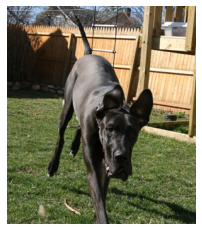

Beam Search, K = 15: dogs play in the yard


In [49]:
pic = '343218198_1ca90e0734.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.axis('off')
plt.show()

print("Beam Search, K = 15:",beam_search_predictions(image, beam_index = 15))

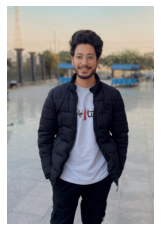

Beam Search, K = 10: a young boy wearing a shirt and a short hat is smiling


In [48]:
# Function for image preprocessing
def preprocess_image(image_path):
    img = keras_image.load_img(image_path, target_size=(299, 299))
    x = keras_image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

# Function for encoding image using InceptionV3 model
def encode_image(model, image):
    fea_vec = model.predict(image)
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

# Load and preprocess InceptionV3 model
inception_model = InceptionV3(weights='imagenet', include_top=False, pooling='avg')

# Path to the new image
new_image_path = '/kaggle/input/test222/abdienoo.jpg'  # Replace with the path to the new image

# Preprocess and encode the image
new_image_processed = preprocess_image(new_image_path)
new_image_encoded = encode_image(inception_model, new_image_processed)

# Reshape the image for input to the prediction model
new_image_encoded = new_image_encoded.reshape((1, 2048))

# Display the image
plt.imshow(plt.imread(new_image_path))
plt.axis('off')
plt.show()

# Use Beam Search for caption prediction
print("Beam Search, K = 10:", beam_search_predictions(new_image_encoded, beam_index=10))

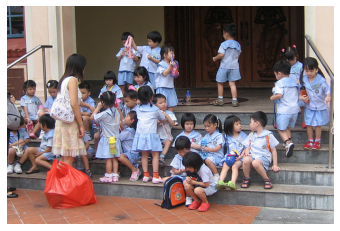

Beam Search, K = 15: a large group of people posing for a picture


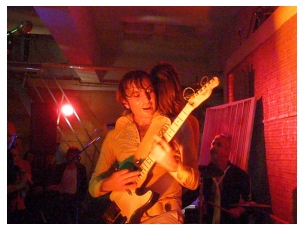

Beam Search, K = 15: a group of people play instruments and sing


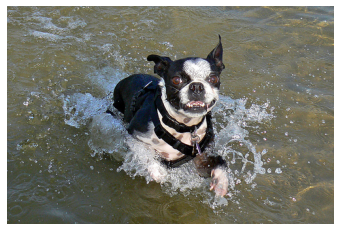

Beam Search, K = 15: black dog with a collar running in the surf


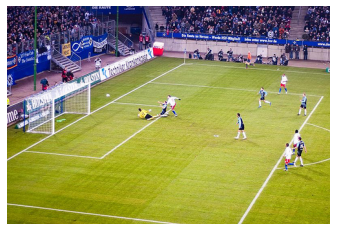

Beam Search, K = 15: many people are playing a soccer type game


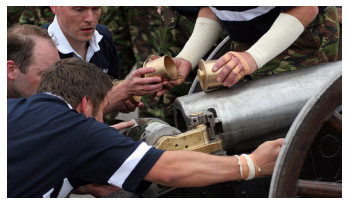

Beam Search, K = 15: a group of people sit on the side of a city street


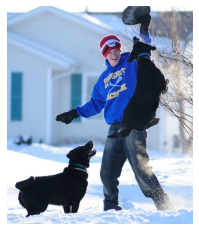

Beam Search, K = 15: a brown dog and a black dog are standing chase each other in the snow


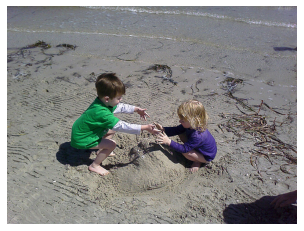

Beam Search, K = 15: a couple sitting on the edge of a river


In [50]:
for pic in list(encoding_test.keys())[18:25]:
    image = encoding_test[pic].reshape((1,2048))
    x=plt.imread(images_path+pic)
    plt.imshow(x)
    plt.axis('off')
    plt.show()

    print("Beam Search, K = 15:",beam_search_predictions(image, beam_index = 15))